In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, date


from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

from datetime import datetime, date
import csv

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = 4.8,3.2
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.fancybox'] = True


In [43]:
plot_spatialkde = False

# Read data

In [17]:
# Read data
fulldf = pd.read_pickle('../data/trafficcollisions.p')

lowercase = 'trafficcollisions'
uppercase = 'Traffic Collisions'

# Add month and columns
fulldf['month'] = fulldf.date.apply(lambda x: x.month)

# Read weather data
weatherfull = pd.read_pickle(r"../data/noaa-weather-downtown-sf.p")


# Convert celsius to fahrenheit
def celsius2fahrenheit(T):
    return T * 1.8 + 32
weatherfull['TMAX'] = weatherfull['TMAX'].apply(celsius2fahrenheit)
weatherfull['TMIN'] = weatherfull['TMIN'].apply(celsius2fahrenheit)

# Join with weather
print 'merge with weather'
print 'before merge', fulldf.shape
fulldf = fulldf.merge(weatherfull,how="inner",left_on="date",right_on="DATE")
print 'after merge', fulldf.shape
print ''

# Filter out 2016 incidents
df = fulldf[fulldf.year < 2016]
print 'fulldf', fulldf.shape
print 'df 2003-2015', df.shape
print ''
weather = weatherfull[weatherfull.DATE < date(2016, 1, 1)]
print 'full weather', weatherfull.shape
print 'weather 2003-2015', weather.shape
print ''


# Aggregate into daily counts
groupbydate = df.groupby(by=['date','dayofweek','month','year','PRCP','TMAX','TMIN']).size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
print 'days from 2003/01/01 to 2015/12/31 :', date(2016,1,1)-date(2003,1,1)
print 'daily aggregate', groupbydate.shape

# Add zero counts for missing days
groupbydate = groupbydate[['date','dayofweek','month','year','count']].merge(weather,how="outer",left_on="date",right_on="DATE")
groupbydate['date']=groupbydate['DATE']
groupbydate.drop('DATE',axis=1,inplace=True)
print 'new daily aggregate', groupbydate.shape
groupbydate[groupbydate.isnull().any(axis=1)]

merge with weather
before merge (10459, 22)
after merge (10459, 26)

fulldf (10459, 26)
df 2003-2015 (10306, 26)

full weather (4836, 4)
weather 2003-2015 (4748, 4)

days from 2003/01/01 to 2015/12/31 : 4748 days, 0:00:00
daily aggregate (4007, 8)
new daily aggregate (4748, 8)


,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4007,2003-01-02,NaN,NaN,NaN,NaN,0.0,57.02,48.02
4008,2003-01-04,NaN,NaN,NaN,NaN,0.0,66.02,50.00
4009,2003-01-20,NaN,NaN,NaN,NaN,0.5,51.08,44.06
4010,2003-01-24,NaN,NaN,NaN,NaN,0.0,62.96,53.96
4011,2003-02-14,NaN,NaN,NaN,NaN,0.0,60.08,51.98
4012,2003-02-17,NaN,NaN,NaN,NaN,0.0,60.98,46.94
4013,2003-02-24,NaN,NaN,NaN,NaN,1.0,60.08,51.08
4014,2003-03-11,NaN,NaN,NaN,NaN,0.0,62.06,51.08
4015,2003-03-12,NaN,NaN,NaN,NaN,0.0,62.96,53.06
4016,2003-03-22,NaN,NaN,NaN,NaN,0.0,59.00,50.00


In [20]:
# Fill in NaNs with proper data

groupbydatena = groupbydate.loc[groupbydate[groupbydate.isnull().any(axis=1)].index,:]
groupbydatena['count'] = 0
groupbydatena['month'] = groupbydatena['date'].apply(lambda x: x.month)
groupbydatena['year'] = groupbydatena['date'].apply(lambda x: x.year)
groupbydatena['dayofweek'] = groupbydatena['date'].apply(lambda x: x.strftime("%A"))

groupbydate.loc[groupbydate[groupbydate.isnull().any(axis=1)].index,:] = groupbydatena

groupbydate.tail()

,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4743,2015-11-30,Monday,11.0,2015.0,0.0,0.0,53.96,44.06
4744,2015-12-06,Sunday,12.0,2015.0,0.0,1.3,60.08,51.08
4745,2015-12-19,Saturday,12.0,2015.0,0.0,3.3,55.04,48.02
4746,2015-12-23,Wednesday,12.0,2015.0,0.0,0.5,53.96,48.02
4747,2015-12-26,Saturday,12.0,2015.0,0.0,0.0,53.06,44.06


In [21]:
# Sort by date
groupbydate.sort_values('date',inplace=True)
groupbydate.reset_index(drop=True,inplace=True)
groupbydate.tail()

,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4743,2015-12-27,Sunday,12.0,2015.0,2.0,0.0,46.94,39.02
4744,2015-12-28,Monday,12.0,2015.0,2.0,1.5,48.92,39.92
4745,2015-12-29,Tuesday,12.0,2015.0,1.0,0.0,55.04,41.00
4746,2015-12-30,Wednesday,12.0,2015.0,1.0,0.8,48.02,41.00
4747,2015-12-31,Thursday,12.0,2015.0,3.0,0.0,51.08,42.08


In [34]:
print "Total collisions:", df.shape[0]
print "Total injured:", df['COUNT_PED_INJURED'].sum()
print "Total killed:", df['COUNT_PED_KILLED'].sum()
print "Daily average collisions:", groupbydate['count'].mean()

Total collisions: 10306
Total injured: 10177
Total killed: 228
Daily average collisions: 2.17059814659


# Over time

## Yearly counts

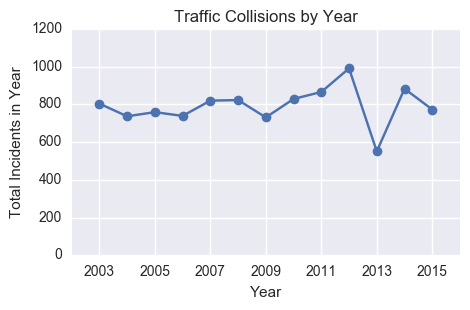

In [24]:
yearlytotal = df.year.value_counts().to_frame(name="count").sort_index()
yearlytotal['year'] = yearlytotal.index
plt.plot(yearlytotal['year'],yearlytotal['count'],'o-')
plt.xlabel('Year')
plt.ylabel('Total Incidents in Year')
plt.title(uppercase+' by Year')
plt.axis([2002, 2016, 0, 1200])
plt.xticks(range(2003,2016,2), range(2003,2016,2))
plt.tight_layout()
plt.savefig('plots/%s-yearlycounts.png' % lowercase)
plt.savefig('plots/%s-yearlycounts-transp.png' % lowercase, transparent=True)

pass

## Aggregated by month

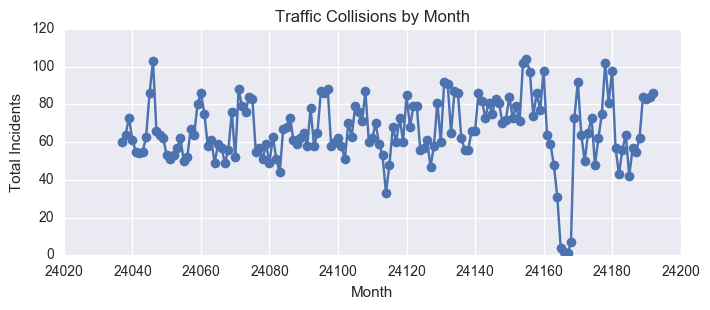

In [25]:
def monthyear2num(month,year):
    return year*12 + month

def num2monthyear(num):
    month = num % 12
    year = (num-month) / 12
    return "%.2d/%.2d" % (month,year)

groupbyyearmonth = df[['year','month']].groupby(by=['year','month']).size().to_frame(name="count")
groupbyyearmonth.reset_index(inplace=True)
groupbyyearmonth['monthyear'] = groupbyyearmonth.apply(lambda row: row['year']*12 + row['month'],axis=1)

plt.figure(figsize=(7.2,3.2))
plt.plot(groupbyyearmonth['monthyear'],groupbyyearmonth['count'],'o-')
plt.xlabel('Month')
plt.ylabel('Total Incidents')
plt.title(uppercase+' by Month')
plt.tight_layout()
pass

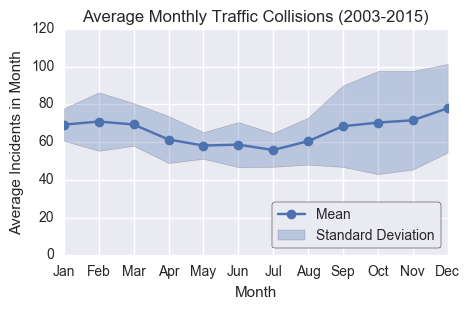

In [30]:
groupbymonth = groupbyyearmonth[['month','count']].groupby(by='month')
groupbymonth = groupbymonth['count'].agg({'sum' : sum, 'mean' : np.mean, 'std' : np.std})

plot_mean = plt.plot(groupbymonth.index,groupbymonth['mean'],'o-')
plot_std = plt.fill_between(groupbymonth.index, 
                 groupbymonth['mean']-groupbymonth['std'], 
                 groupbymonth['mean']+groupbymonth['std'],
                 alpha=.3)
plt.xlabel('Month')
plt.ylabel('Average Incidents in Month')
plt.title('Average Monthly %s (2003-2015)' % uppercase)
leg = plt.legend(['Mean','Standard Deviation'],loc='lower right')
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.axis([1, 12, 0, 120])

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.tight_layout()
plt.savefig('plots/%s-monthlyaverage.png' % lowercase)
plt.savefig('plots/%s-monthlyaverage-transp.png' % lowercase, transparent=True)

pass


## Daily counts over time

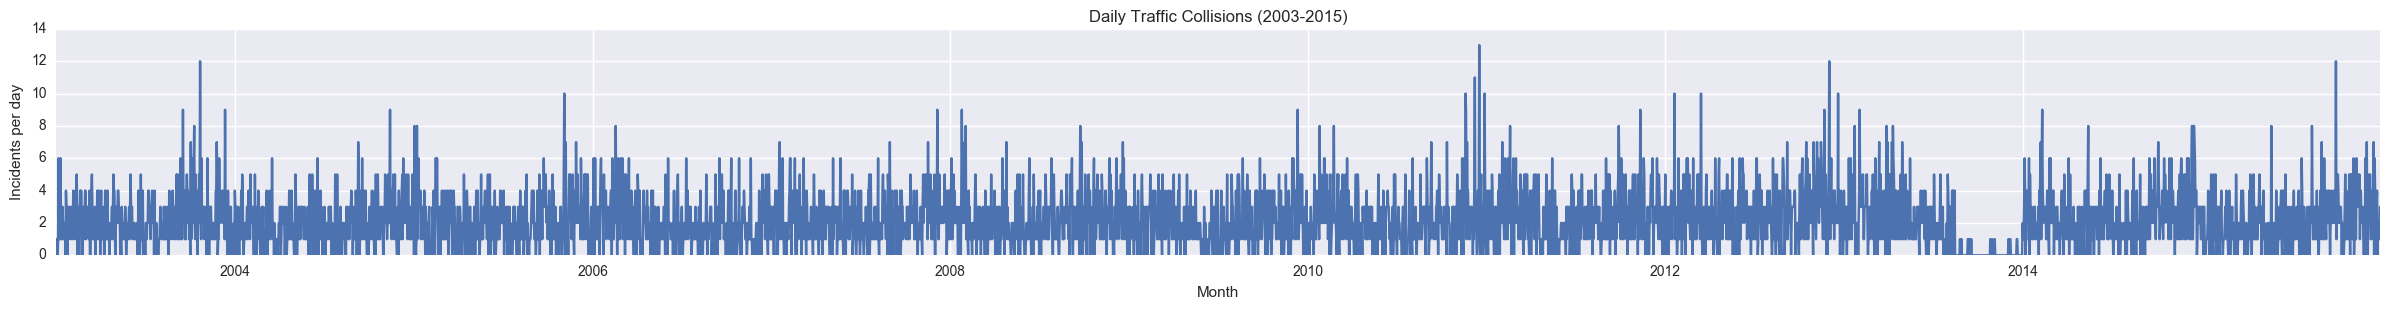

In [31]:
plt.figure(figsize=(4.8*5,3.2))
plt.plot(groupbydate['date'],groupbydate['count'],'-')
plt.xlabel('Month')
plt.ylabel('Incidents per day')
plt.title('Daily %s (2003-2015)' % uppercase)
plt.tight_layout()
pass

# Time of Day

In [35]:
def time2num(t):
    ts = t.hour * 60 + t.minute
    return ts

def scott_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 1.06*sigma*S.count()**(-0.2)

def silverman_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 0.9*sigma*S.count()**(-0.2)

class WrappedKDE:
    
    def __init__(self,S):
        # S is a pandas series
        self.bandwidth = silverman_bw(S)
        self.model = KernelDensity(bandwidth=self.bandwidth)
        return None
        
    def fit(self,data):
        self.model.fit(data.reshape(-1,1))
        return self
    
    def pdf(self,grid):
        grid = grid.reshape(-1,1)
        griddelta = grid[1]-grid[0]
        gridmax = grid[-1]+griddelta
        out = np.exp(self.model.score_samples(grid))
        out += np.exp(self.model.score_samples(grid-gridmax))
        out += np.exp(self.model.score_samples(grid+gridmax))
        return out

timekde = WrappedKDE(df.time.apply(time2num))
timekde.fit(df.time.apply(time2num))
print timekde.bandwidth
#timegrid = np.arange(1,1440,1)
#plt.scatter(timegrid, timekde.pdf(timegrid))
#plt.axis([0, 1440, 0, 0.002])

48.1347334695


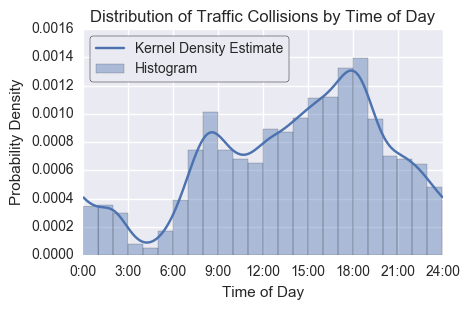

In [37]:
hours = ['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00']
#plt.hist(df.time.apply(time2num),bins=24,normed=True,alpha=0.5)
sns.distplot(df.time.apply(time2num),kde = False,norm_hist=True,bins=24)

timegrid = np.arange(1,1440,1)
plt.plot(timegrid,timekde.pdf(timegrid),'-',color=sns.color_palette()[0])

plt.axis([0,1440,0,0.0016])
plt.xticks(range(0,1441,180), hours)

plt.xlabel('Time of Day')
plt.ylabel('Probability Density')
plt.title('Distribution of %s by Time of Day' % uppercase)
legloc = 'best'
leg = plt.legend(['Kernel Density Estimate','Histogram'],loc=legloc)
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.tight_layout()
plt.savefig('plots/%s-timeofdaydistribution.png' % lowercase)
plt.savefig('plots/%s-timeofdaydistribution-transp.png' % lowercase, transparent=True)

pass

# Day of Week

   dayofweekno  dayofweek       std     sum      mean  size    stderr
0            1     Monday  1.612242  1403.0  2.069322   678  0.061918
1            2    Tuesday  1.663899  1545.0  2.278761   678  0.063902
2            3  Wednesday  1.743313  1638.0  2.412371   679  0.066902
3            4   Thursday  1.692910  1585.0  2.334315   679  0.064968
4            5     Friday  1.987870  1708.0  2.519174   678  0.076344
5            6   Saturday  1.592830  1340.0  1.976401   678  0.061172
6            7     Sunday  1.408076  1087.0  1.603245   678  0.054077


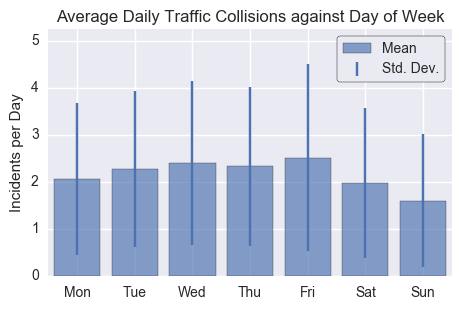

In [41]:
weekdayno ={ 
    u'Monday' : 1,
    u'Tuesday' : 2,
    u'Wednesday' : 3,
    u'Thursday' : 4,
    u'Friday' : 5,
    u'Saturday' : 6,
    u'Sunday' : 7
    }
groupbydate['dayofweekno'] = groupbydate['dayofweek'].apply(lambda x: weekdayno[x])

groupbyweekday = groupbydate.groupby(by=['dayofweekno','dayofweek'])
groupbyweekday = groupbyweekday['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyweekday['stderr'] = groupbyweekday.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
groupbyweekday.reset_index(inplace=True)

print groupbyweekday

weekdaylabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

p = plt.bar(left=groupbyweekday['dayofweekno'].as_matrix(),
           height=groupbyweekday['mean'].as_matrix(),
           width=0.8,
           tick_label=weekdaylabels,
           align='center',
           yerr = groupbyweekday['std'],
           alpha=0.66)
plt.title('Average Daily %s against Day of Week' % uppercase)
plt.ylabel('Incidents per Day')
leg = plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='upper right')
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.axis([0.5,7.5,0,5.25])
plt.tight_layout()
plt.savefig('plots/%s-dayofweekaverage.png' % lowercase)
plt.savefig('plots/%s-dayofweekaverage-transp.png' % lowercase, transparent=True)

pass

# Spatial KDE

In [42]:
# Fit spatial KDE

def silverman_bwxy(df):
    count = df['x'].count()
    stdx = df['x'].std()
    stdy = df['y'].std()
    iqrx = np.subtract(*np.percentile(df['x'], [75, 25]))
    iqry = np.subtract(*np.percentile(df['y'], [75, 25]))
    sigma = min(stdx,stdy,iqrx,iqry)
    return 0.9*sigma*count**(-0.2)

spacekde = KernelDensity(bandwidth = silverman_bwxy(df[['x','y']]),metric='haversine')
spacekde.fit(df[['x','y']])


KernelDensity(algorithm='auto', atol=0, bandwidth=0.0043706768741898173,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='haversine', metric_params=None, rtol=0)

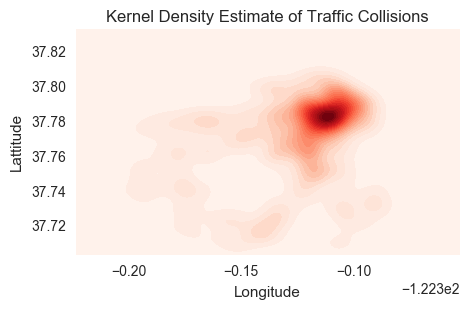

In [44]:
# Sample on a grid

xmin = -122.5237517
xmax = -122.3522017
ymin = 37.7040012
ymax = 37.8341382

xv, yv = np.meshgrid(np.arange(xmin,xmax,0.0004),np.arange(ymin,ymax,0.0004))
#xv, yv = np.meshgrid(np.linspace(xmin,xmax,num=400),np.linspace(ymin,ymax,num=100))

X_grid = np.vstack([xv.ravel(), yv.ravel()]).transpose()

if plot_spatialkde:

    Z = np.exp(spacekde.score_samples(X_grid))
    Zv = Z.reshape(xv.shape)

    levels = np.linspace(Zv.min(), Zv.max(), 25)
    plt.contourf(xv, yv, Zv, levels=levels, cmap=plt.cm.Reds)
    plt.title('Kernel Density Estimate of %s' % uppercase)
    plt.xlabel('Longitude')
    plt.ylabel('Lattitude')
    plt.tight_layout()
    plt.savefig('plots/%s-spatialkdeheatmap.png' % lowercase)
    plt.savefig('plots/%s-spatialkdeheatmap-transp.png' % lowercase, transparent=True)
    
    # Save sampled data to file

    Z_filt = Z/Z.max()

    tol = 1e-4
    Z_filt[abs(Z_filt) < tol] = 0.0

    out = [[point[0], point[1], point[2]] for point in zip(X_grid[:,1],X_grid[:,0],Z_filt)]

    with open("%s_kde.csv" % lowercase, "wb") as f:
        writer = csv.writer(f)
        writer.writerows(out)
